In [22]:
#Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F

from Signal_Analyzer import  *
from UNetGenerator import *

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [23]:
class UNetDiscriminator(nn.Module):
    def __init__(self, input_channels, num_latent_variables, base_channels=64):
        super(UNetDiscriminator, self).__init__()

        # Initial convolution block
        self.init_conv = nn.Conv1d(input_channels, base_channels, kernel_size=3, stride=1, padding=1)
        self.init_leaky_relu = nn.LeakyReLU(0.2, inplace=True)

        self.res_block_no_norm = ResBlock(base_channels, base_channels, num_latent_variables, no_norm=True)

        # Down-sampling layers
        self.down1 = Down(base_channels, base_channels * 2, num_latent_variables)
        self.down2 = Down(base_channels * 2, base_channels * 4, num_latent_variables)
        self.down3 = Down(base_channels * 4, base_channels * 8, num_latent_variables)

        # Flatten and Dense layers
        self.flatten = nn.Flatten()
        self.dense1 = nn.Linear(base_channels * 8 * (1000 // 2 // 2 // 2), 128)
        self.dense_leaky_relu = nn.LeakyReLU(0.2)
        self.layer_norm = nn.LayerNorm(128)
        self.final_dense = nn.Linear(128, 1)

    def forward(self, x, z):
        # Pass through initial conv layer and Leaky ReLU
        x = self.init_conv(x)
        x = self.init_leaky_relu(x)

        # Pass through ResBlock without normalization
        x = self.res_block_no_norm(x, z)

        # Down-sampling steps
        x = self.down1(x, z)
        x = self.down2(x, z)
        x = self.down3(x, z)

        # Flatten and pass through dense layers
        x = self.flatten(x)
        x = self.dense1(x)
        x = self.dense_leaky_relu(x)
        x = self.layer_norm(x)
        x = self.final_dense(x)

        return x

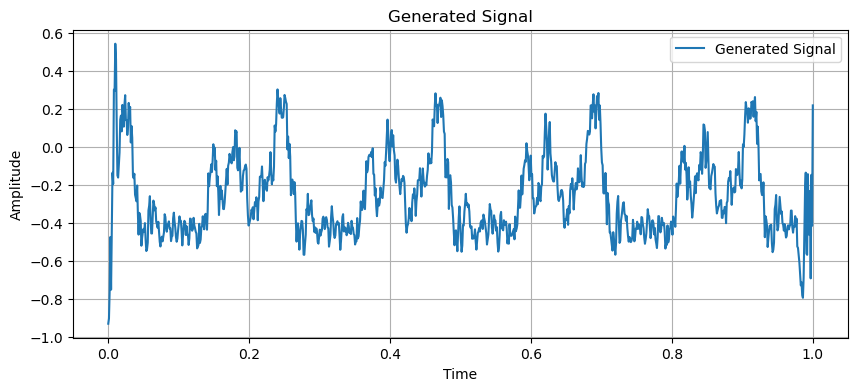

In [24]:
t = np.linspace(0, 1, 1000)

num_latent_variables = 10

z = torch.randn(1, num_latent_variables, 1)


amplitude_range=(0.5, 1.5)
phase_range=(0, np.pi)
frequency_range=(1, 5)

amplitude = np.random.uniform(*amplitude_range)
phase = np.random.uniform(*phase_range)
frequency = np.random.uniform(*frequency_range) 

input_signal = amplitude * np.sin(2 * np.pi * frequency * t + phase)
input_signal_tensor = torch.tensor(input_signal, dtype=torch.float).unsqueeze(0).unsqueeze(0)

# Initialize the generator
generator = UNetGenerator(in_channels=1, num_latent_variables=num_latent_variables)

# Generate the signal with the corrected generator
with torch.no_grad():
    generated_signal = generator(input_signal_tensor, z).squeeze().numpy()

plt.figure(figsize=(10, 4))
plt.plot(t, generated_signal, label='Generated Signal')
plt.title('Generated Signal')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.show()

In [25]:
discriminator = UNetDiscriminator(input_channels=1, num_latent_variables=num_latent_variables)

with torch.no_grad():
    generated_signal_tensor = torch.tensor(generated_signal, dtype=torch.float).unsqueeze(0).unsqueeze(0)
    discriminator_output_generated = discriminator(generated_signal_tensor, z)

    discriminator_output_input = discriminator(input_signal_tensor, z)

print(discriminator_output_generated.item())
print(discriminator_output_input.item())

-0.026033923029899597
0.056556135416030884
